In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy
import pickle
import copy

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.control.optimal_control import oc_wc, cost_functions
from neurolib.experiments.WPtwo.onen.plot import plot_1n_osc, plot_1n_osc_noisy, set_labels

import matplotlib as mpl

set_labels()

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

while "Promotion/neurolib" in os.getcwd():
    os.chdir('..')

pickledir = os.path.join(os.getcwd(), "neurolib_aln_osc_datastorage/optimal_control/WP2/1n")
dir = os.path.join(pickledir, "images_1n_wc")

print(dir)

/home/lena/Promotion/neurolib_aln_osc_datastorage/optimal_control/WP2/1n/images_1n_wc


In [2]:
coords = [[1., 1.], [3., 1.]]

data = dict()
data["coordinates"] = [coords[0], coords[1]]
data["control"] = [None , None]
data["state"] = [None , None]
data["init_state"] = [None , None]

N = 1
model = WCModel()
dt = model.params['dt']

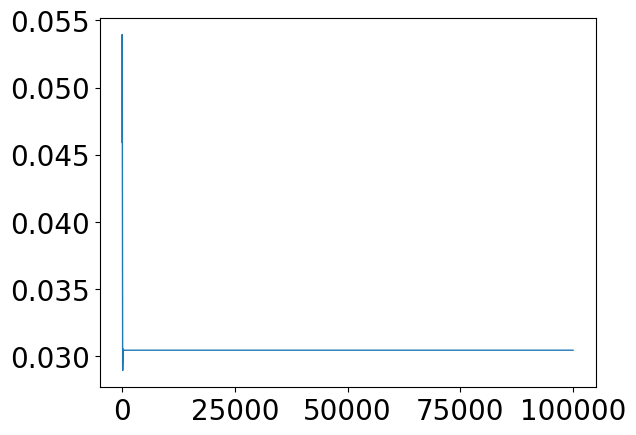

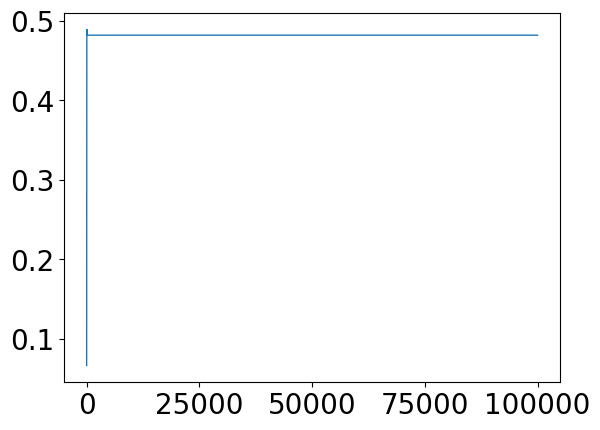

In [3]:
model = WCModel()
testd = 1e4
model.params.duration = testd
model.params.dt = dt

for ci in range(2):
    model.params.exc_ext_baseline = data["coordinates"][ci][0]
    model.params.inh_ext_baseline = data["coordinates"][ci][1]

    model.run()

    plt.plot(model.exc[0,:])
    plt.show()

    einit = np.zeros((N, 1))
    iinit = np.zeros((N, 1))
    for n in range(N):
        einit[n,:] = model.exc[n,-1]
        iinit[n,:] = model.inh[n,-1]

    data["init_state"][ci] = [einit, iinit]

In [4]:
from numba.typed import Dict
from numba.core import types

weights = Dict.empty(
        key_type=types.unicode_type,
        value_type=types.float64,
    )

weights["w_2"] = 1.0
weights["w_1"] = 0.0
weights["w_1T"] = 0.0
weights["w_1D"] = 0.0

controlmat = np.zeros((N,4))
controlmat[0,0] = 1

costmat = np.zeros((N, 3))
costmat[:,0] = 1.

duration = 400.
target_period = 30

int0 = 500
int1 = 3500

model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( ([zero_input0]*2) )[np.newaxis,:,:]
zero_control = np.vstack( ([zero_input]*N))

it = 5
maxstr = 5
pr = np.arange(0,101,10)

In [5]:
energy_input = np.zeros((2))

In [8]:
print(1/(1e-4 * 1.6))

6249.999999999999


Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1376.258557333057
Final cost : -1376.258557333057
Compute control for a deterministic system
Cost in iteration 0: -1376.258557333057
Converged in iteration 4 with cost -1376.258557333057
Final cost : -1376.258557333057
Compute control for a deterministic system
Cost in iteration 0: -1376.258557333057
Converged in iteration 2 with cost -1376.258557333057
Final cost : -1376.258557333057
Compute control for a deterministic system
Cost in iteration 0: -1376.258557333057
Converged in iteration 3 with cost -1376.258557333057
Final cost : -1376.258557333057
Compute control for a deterministic system
Cost in iteration 0: -1376.258557333057
Converged in iteration 2 with cost -1376.258557333057
Final cost : -1376.258557333057
Compute control for a deterministic system
Cost in iteration 0: -1376.258557333057
Converged in iteration 1 with cost -1376.258557333057
Final cost : -1376.258557

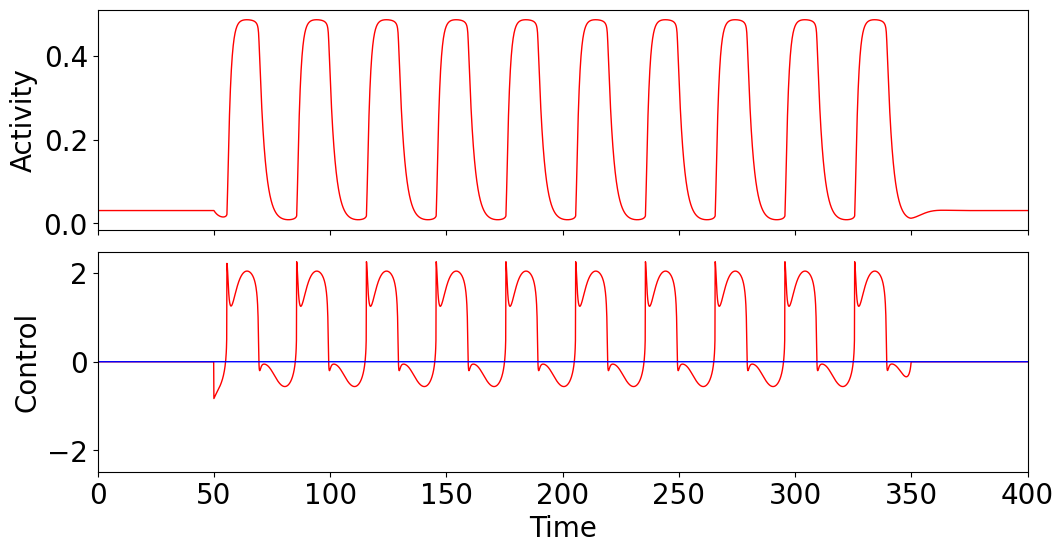

In [66]:
ci = 0

it = 100
w_f = 0.8 * 1e5

model = WCModel()
model.params.exc_init = data["init_state"][ci][0]
model.params.inh_init = data["init_state"][ci][1]

model.params["exc_ext_baseline"] =  data["coordinates"][ci][0]
model.params["inh_ext_baseline"] =  data["coordinates"][ci][1]
model.params.duration = duration

model.run()

model.params["ext_exc_current"] = zero_control[:,0,:]
model.params["ext_inh_current"] = zero_control[:,1,:]

for factor in [1]:
#for factor in 4. * np.random.random(10):

    model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0, int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = 1.
    model_controlled.weights["w_f"] = w_f

    model_controlled.maximum_control_strength = maxstr

    if True:
        if type(data["control"][ci]) != type(None):
            model_controlled.control = data["control"][ci]
            #model_controlled.control[:,0,:4000] = 0
            model_controlled.update_input()

    model_controlled.optimize(0)
    
    for j in range(1):
        model_controlled.grad_method = 0
        model_controlled.channelwise_optimization = True

        for l in range(0):
            for k in [18]:
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

        model_controlled.grad_method = 0
        model_controlled.channelwise_optimization = True

        for l in range(1):
            for k in np.arange(-6., 7., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)
        
        model_controlled.grad_method = 1

        for l in range(1):
            for k in np.arange(-4., 5., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    print("gradient = ", np.amax(np.abs(model_controlled.gradient)))

    data["control"][ci] = model_controlled.control.copy()
    data["state"][ci] = model_controlled.get_xs()

energy_input[0] = cost_functions.control_strength_cost(model_controlled.control, weights, dt)
#print("cost of control = ", cost_functions.control_strength_cost(data["control"][fi][wi], weights, dt))
plot_control_1(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

Optimal control with target oscillation period
Compute control for a deterministic system
Cost in iteration 0: -1416.3634217910646
Final cost : -1416.3634217910646
Compute control for a deterministic system
Cost in iteration 0: -1416.3634217910646
Converged in iteration 3 with cost -1416.3634217910646
Final cost : -1416.3634217910646
Compute control for a deterministic system
Cost in iteration 0: -1416.3634217910646
Converged in iteration 6 with cost -1416.3634217910653
Final cost : -1416.3634217910653
Compute control for a deterministic system
Cost in iteration 0: -1416.3634217910653
Converged in iteration 1 with cost -1416.3634217910653
Final cost : -1416.3634217910653
Compute control for a deterministic system
Cost in iteration 0: -1416.3634217910653
Converged in iteration 1 with cost -1416.3634217910653
Final cost : -1416.3634217910653
Compute control for a deterministic system
Cost in iteration 0: -1416.3634217910653
Converged in iteration 1 with cost -1416.3634217910653
Final cos

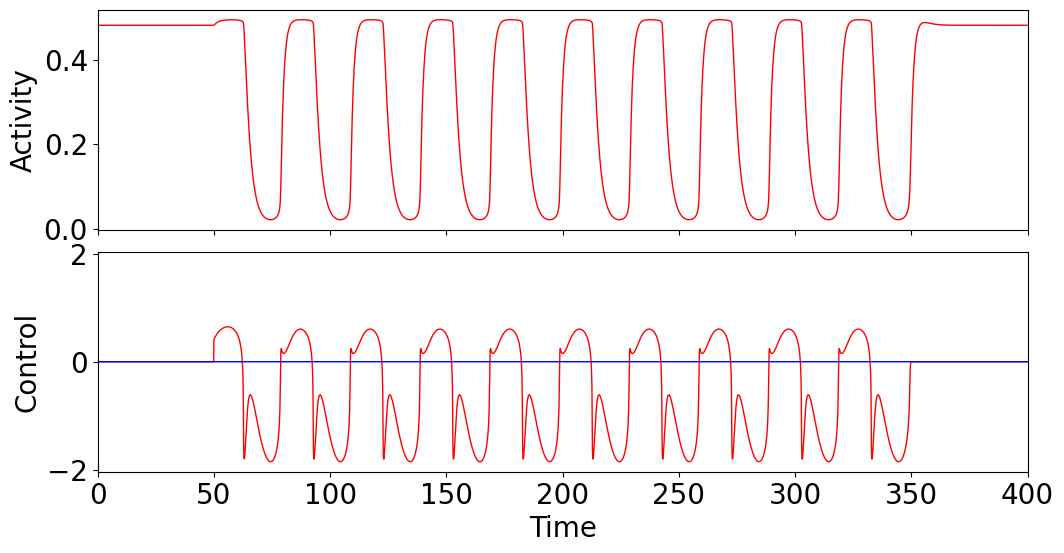

In [84]:
ci = 1

it = 100
w_f = 8*1e4

model = WCModel()
model.params.exc_init = data["init_state"][ci][0]
model.params.inh_init = data["init_state"][ci][1]

model.params["exc_ext_baseline"] =  data["coordinates"][ci][0]
model.params["inh_ext_baseline"] =  data["coordinates"][ci][1]
model.params.duration = duration

model.run()


model.params["ext_exc_current"] = zero_control[:,0,:]
model.params["ext_inh_current"] = zero_control[:,1,:]

for factor in [1]:
#for factor in 4. * np.random.random(10):

    model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0, int1), control_interval=(int0, int1), cost_matrix=costmat, control_matrix=controlmat)
    model_controlled.weights["w_p"] = 0.
    model_controlled.weights["w_2"] = 1.
    model_controlled.weights["w_f"] = w_f

    model_controlled.maximum_control_strength = maxstr

    if True:
        if type(data["control"][ci]) != type(None):
            model_controlled.control = data["control"][ci]
            #model_controlled.control[:,0,:4000] = 0
            model_controlled.update_input()

    model_controlled.optimize(0)
    
    for j in range(1):
        model_controlled.grad_method = 0
        model_controlled.channelwise_optimization = True

        for l in range(0):
            for k in [15]:
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)

        for l in range(1):
            for k in np.arange(-3., 7., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(it)
        
        model_controlled.grad_method = 1

        for l in range(1):
            for k in np.arange(-4., 5., 2.):
                model_controlled.zero_step_encountered = False
                model_controlled.step = 10**(k)
                model_controlled.optimize(10)

    data["control"][ci] = model_controlled.control.copy()
    data["state"][ci] = model_controlled.get_xs()

energy_input[1] = cost_functions.control_strength_cost(model_controlled.control, weights, dt)
#print("cost of control = ", cost_functions.control_strength_cost(data["control"][fi][wi], weights, dt))
plot_control_1(model_controlled.control, model_controlled.get_xs(), duration, dt, filename=None, title=None)

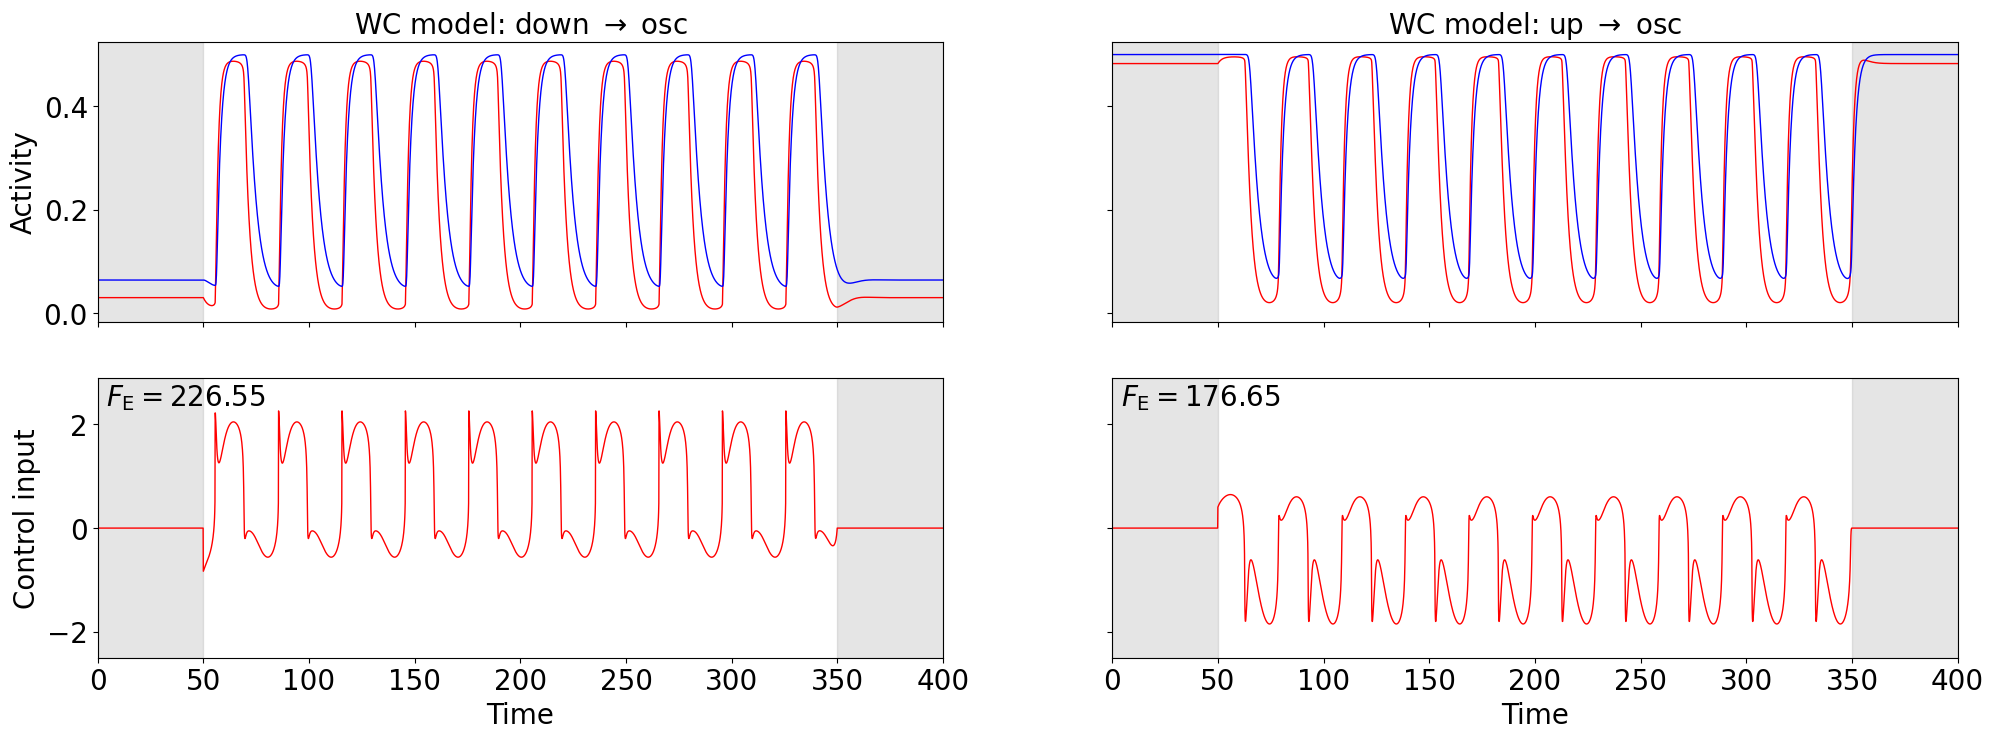

In [80]:
fig, ax = plt.subplots(2,2, figsize=(24,8), sharex=True, sharey="row")

ax[0,0].set_title(r"WC model: down $\rightarrow$ osc")
ax[0,1].set_title(r"WC model: up $\rightarrow$ osc")

time = np.arange(0, duration+dt, dt)

for ci in range(2):
    ax[0,ci].plot(time, data["state"][ci][0,0,:], color="red", label="E")
    ax[0,ci].plot(time, data["state"][ci][0,1,:], color="blue", label="I")
    ax[1,ci].plot(time, data["control"][ci][0,0,:], color="red")

ax[0,0].set_label("upper right")

ax[1,0].set_xlabel("Time")
ax[1,1].set_xlabel("Time")
ax[0,0].set_ylabel("Activity")
ax[1,0].set_ylabel("Control input")

ax[0,0].set_xlim(0, duration)
ax[1,0].set_ylim(-2.5, 2.9)

alpha = 0.2

for ci in range(2):
    for k in range(2):
        ax[k,ci].axvspan(0, 50, color="grey", alpha=alpha)
        ax[k,ci].axvspan(350, 400, color="grey", alpha=alpha)

    ax[1,ci].text(0.01, 0.9, r"$F_\text{E} = $" + "{0:.2f}".format(energy_input[ci]), transform=ax[1,ci].transAxes)


plt.savefig(os.path.join(dir, "wc_stat_osc.pdf"), bbox_inches='tight')

In [67]:
with open(os.path.join(pickledir, 'osc_1n_wc.pickle'), 'wb') as f:
    pickle.dump(data, f)

In [48]:
with open(os.path.join(pickledir, 'osc_1n_wc.pickle'), 'rb') as f:
    res_read = pickle.load(f)
    print(res_read.keys() )

data = res_read.copy()

dict_keys(['coordinates', 'control', 'state', 'init_state'])


In [7]:
def plot_control_1(c, s, dur, dt, filename=None, title=None):
    fig, ax = plt.subplots(2,1, figsize=(12,6), sharex=True)
    time_array = np.arange(0, dur+dt, dt)

    cmax = np.amax(np.abs(c))
    y1lim = [-cmax* 1.1, cmax* 1.1]

    for n in range(N):
        ax[0].plot(time_array, s[n,0,:], color="red")
        ax[1].plot(time_array, c[n,0,:], color="red")
        ax[1].plot(time_array, c[n,1,:], color="blue")

    ax[0].set_xlim(0, dur)

    ax[1].set_ylim(y1lim)

    ax[1].set_xlabel("Time")
    ax[0].set_ylabel("Activity")
    ax[1].set_ylabel("Control")

    plt.subplots_adjust(
                    wspace=0.15,
                    hspace=0.1)
    
    fig.align_ylabels([ax[0]])
    
    if title is not None:
        fig.suptitle(title)

    if filename is not None:
        plt.savefig(filename, bbox_inches='tight', dpi=200)

    plt.show()
    return